In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from os.path import expanduser
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from pprint import pprint
from factslab.utility.lcsreader import LexicalConceptualStructureLexicon
from factslab.utility import ridit, r1_score, dev_mode_group

home = expanduser('~')
%matplotlib inline
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', -1)

# Load the data

In [2]:
attributes_pred = ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']
pred_datafile = home + "/Research/protocols/data/pred_raw_data_norm_122218.tsv"
pred_data = pd.read_csv(pred_datafile, sep="\t")
pred_data = pred_data[pred_data['Split'].isin(['train', 'dev'])]
pred_data_unq = pred_data.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_pred, type="regression")).reset_index(drop=True)
print("Predicate train + dev data unique shape", pred_data.shape)

attributes_arg = ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']
arg_datafile = home + "/Research/protocols/data/noun_raw_data_norm_122218.tsv"
arg_data = pd.read_csv(arg_datafile, sep="\t")
arg_data = arg_data[arg_data['Split'].isin(['train', 'dev'])]
arg_data_unq = arg_data.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_arg, type="regression")).reset_index(drop=True)
print("Argument train + dev data unique shape", arg_data.shape)

Predicate train + dev data unique shape (36549, 29)
Argument train + dev data unique shape (40883, 27)


In [28]:
pred_datafile_2 = home + "/Research/protocols/data/pred_raw_data_norm_122218.tsv"
pred_data_2 = pd.read_csv(pred_datafile_2, sep="\t")
pred_data_unq_2 = pred_data_2.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_pred, type="regression")).reset_index(drop=True)
display(pred_data_unq_2.shape)

(33113, 29)

In [30]:
arg_datafile_2 = home + "/Research/protocols/data/noun_raw_data_norm_122218.tsv"
arg_data_2 = pd.read_csv(arg_datafile_2, sep="\t")
arg_data_unq_2 = arg_data_2.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_arg, type="regression")).reset_index(drop=True)
display(arg_data_unq_2.shape)

(37146, 27)

# Concreteness correlations

In [3]:
conc_data = arg_data_unq.copy()

path = home + "/Research/protocols/data/concreteness.tsv"
conc = pd.read_csv(path, sep="\t")
list_of_lemmas = conc['Word'].values.tolist()

abs_conc = conc_data.groupby('Lemma')['Is.Abstract.Norm'].mean().to_frame().reset_index()
abs_conc['conc'] = abs_conc['Lemma'].map(lambda x: (conc[conc['Word'] == x.lower()]['Conc.M']).values[0] if x.lower() in list_of_lemmas else -1)

ini = len(abs_conc)
abs_conc = abs_conc[abs_conc['conc'] != -1]
print("Percentage of lemmas found in database:", len(abs_conc) / ini)
print("Spearman correlation: ", np.round(spearmanr(abs_conc['Is.Abstract.Norm'].values, abs_conc['conc'].values)[0], 2))
print("Pearson correlation: ", np.round(pearsonr(abs_conc['Is.Abstract.Norm'].values, abs_conc['conc'].values)[0], 2))

Percentage of lemmas found in database: 0.6633102580239144
Spearman correlation:  -0.45
Pearson correlation:  -0.45


# LCS

In [4]:
path = home + "/Research/protocols/data/verbs-English.lcs"
lcs = LexicalConceptualStructureLexicon(path)

lcs_data = pred_data_unq.copy()

dyn_lcs = lcs_data.groupby('Lemma')['Is.Dynamic.Norm'].apply(list).to_frame().reset_index()
dyn_lcs['lcs'] = dyn_lcs['Lemma'].map(lambda x: lcs.eventive(x.lower()) if x.lower() in lcs.verbs else -1)
num_of_lemmas = len(dyn_lcs)
dyn_lcs = dyn_lcs[dyn_lcs['lcs'] != -1]
dyn_lcs.set_index('Lemma', inplace=True)
dyn_lcs['dyn'] = dyn_lcs['Is.Dynamic.Norm'].apply(lambda x: [a > 0 for a in x])
dyn_lcs['comp'] = dyn_lcs.apply(lambda x: 1 if set(x['dyn']).intersection(set(x['lcs'])) else 0, axis=1)

print("Percentage of lemmas found in lcs database:", len(dyn_lcs) / num_of_lemmas)
print("They share at least one sense:", sum(dyn_lcs['comp']) / len(dyn_lcs))

Percentage of lemmas found in lcs database: 0.43727794479365945
They share at least one sense: 0.861875


In [9]:
dyn_lcs['comp'] = dyn_lcs.apply(lambda x: 1 if set(x['dyn']).issubset(set(x['lcs'])) else 0, axis=1)

print("Percentage of lemmas found in lcs database:", len(dyn_lcs) / num_of_lemmas)
print("They share at least one sense:", sum(dyn_lcs['comp']) / len(dyn_lcs))

Percentage of lemmas found in lcs database: 0.43727794479365945
They share at least one sense: 0.396875


In [15]:
from sklearn.metrics import matthews_corrcoef

dyn_lcs['lcs_event'] = dyn_lcs['lcs'].map(lambda x: True in x)
dyn_lcs['udsg_event'] = dyn_lcs['dyn'].map(lambda x: True in x)

dyn_lcs['lcs_state'] = dyn_lcs['lcs'].map(lambda x: False in x)
dyn_lcs['udsg_state'] = dyn_lcs['dyn'].map(lambda x: False in x)

(dyn_lcs['lcs_event']==dyn_lcs['udsg_event']).sum()/num_of_lemmas, (dyn_lcs['lcs_state']==dyn_lcs['udsg_state']).sum()/num_of_lemmas


(0.35528833014484834, 0.1779174637879202)

In [27]:
display(dyn_lcs[(dyn_lcs['lcs_event']==True) & (dyn_lcs['udsg_event']==True) & (dyn_lcs['lcs_state']==True) & (dyn_lcs['udsg_state']==True)])

,Is.Dynamic.Norm,lcs,dyn,comp,lcs_event,udsg_event,lcs_state,udsg_state
Lemma,,,,,,,,
accept,"[0.14989181921041672, -0.09531629069819296, 0.7661451062858519, 1.063444222719334, 0.8100125695250876, 1.145753525941472, 0.6436138864523061, 0.9405894815742868, -0.3704511348881617, 0.5246988627844292, -0.5795089035135333, -0.3629648163281317, 1.1296925552522403, 1.0979930832358349, -1.0731368082336958, 0.9047283825552058, 1.5261923537454258, 1.7603946016207612, 1.7090099423734073, -1.836711070486146, 1.263555611620163, 1.3571135258582383, 0.6351565245211184, 1.5250541027391542, 1.405233602749987, 1.0130610154618749, 1.4044028822110397, -0.8415081924030048, -0.6571209636317346]","[True, False, False, True]","[True, False, True, True, True, True, True, True, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False]",1,True,True,True,True
acknowledge,"[0.5685117846287859, 0.7970149410374195, -0.9183331645834192, 0.3351680313823737, 0.6583967746634813]","[False, False, False, True, True]","[True, True, False, True, True]",1,True,True,True,True
admit,"[0.2367839177782213, 0.5178274273559303, 2.0840013215706787, -0.8443952770479536, 0.4703849287920591, -0.6928995481420592, -1.2672012074092045, 0.3501813483276576, 0.7655263789399682, 1.1079410530035532, 1.003463080618795, 1.2877816141868408, -0.9418973373401828, 0.4220795785332815, 2.078592380257972, 0.7975638122168168, -1.1730562154056998]","[False, True, True]","[True, True, True, False, True, False, False, True, True, True, True, True, False, True, True, True, False]",1,True,True,True,True
adopt,"[-1.4239377945606122, 0.5259356889061672, 0.29163734842979844, 0.5231286077271492, 0.7135634623930612, 0.9379730143548628]","[False, True, True, True]","[False, True, True, True, True, True]",1,True,True,True,True
allow,"[-0.292829964696834, -0.5365488473855263, 0.5825392226546018, -0.06807342143866632, 0.4727884864715322, 0.4129780467456997, 1.2759180733332094, 0.5572130450728608, 0.603186672541811, -0.8029801917744894, -0.8624150460128447, 1.5879970157590226, 0.22068684532799154, -0.0966444758464715, -0.7060602565112364, -1.3507691123627048, 1.0608196094219522, 0.6256911639254159, -0.7767394869422323, -0.9539147125068416, 0.0007798419065501022, -0.272964235435603, 0.7093711273654915, 0.3531318848450519, -1.0210627276727402, 0.4475700833764712, -1.2891623922235458, 0.4883841700830048, 0.98354643130078, -0.9963194597438664, -0.7374146908924728, 1.89027125883956, 0.3472784596513207, 0.32122757306845634, 0.3730888625702919, 0.499384597183289]","[False, True, True]","[False, False, True, False, True, True, True, True, True, False, False, True, True, False, False, False, True, True, False, False, True, False, True, True, False, True, False, True, True, False, False, True, True, True, True, True]",1,True,True,True,True
appear,"[0.16211556429899127, -1.751232422848522, 0.9010501625917232, -0.6584144239756262, 0.09076178362630903, 1.4922945725993708, -0.2816057019573329, -0.3880806204051061, -1.2730236615098125, 0.7806023453228644, -0.20286854090923745, -0.8762667100305649, -1.0523021116804858, -0.2386708427757693, 0.7987534167294745, 1.0652494016285965, -0.953842746589596, -1.0089808674388876, 0.7165705442045796, -0.3139252257695089, 0.4910403711450248, -0.9717056922380832]","[True, False, True]","[True, False, True, False, True, True, False, False, False, True, False, False, False, False, True, True, False, False, True, False, True, False]",1,True,True,True,True
appreciate,"[0.7272724712051266, -0.4584195215961501, -0.3738782099342359, 0.4445408990451611, -0.3891085163315997, 0.014023341001231496, -0.5334565518089514, 0.44803575730328543, 0.6198542423754453, -0.8904347400696773, 0.7267404165102818, 0.9362147980691856, 1.5156698532621509, -0.7397698775707721, -0.28765211052542944, 0.0455738396773324, 1.7329810353575912, -0.8970325096489405, -0.36683541227197897, -1.0611382945438042, -0.14151849462810873, -2.3250099815170544, 1

# Factuality

In [31]:
datafile_ = home + "/Research/protocols/data/it-happened_eng_ud1.2_07092017_normalized.tsv"
fact_data = pd.read_csv(datafile_, sep="\t")

pred_data_f = pred_data_unq.copy()
pred_data_f['Sentence.ID'] = pred_data_f['Sentence.ID'].str.replace('sent_', '', regex=False)
pred_data_f['Unique.ID'] = pred_data_f.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Root.Token"]), axis=1)
pred_data_f = pred_data_f.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_pred, type="regression")).reset_index(drop=True)

fact_data = fact_data[fact_data['Split'].isin(['train', 'dev'])]
fact_data['Unique.ID'] = fact_data.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Pred.Token"] - 1), axis=1)
fact_data = fact_data.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)

hyp_fact = pred_data_f.loc[:, ['Unique.ID', 'Is.Hypothetical.Norm', 'Is.Particular.Norm', 'Is.Dynamic.Norm']]
fact_ids = fact_data['Unique.ID'].tolist()
hyp_fact['Happened.Norm'] = hyp_fact['Unique.ID'].apply(lambda x: fact_data[fact_data['Unique.ID'] == x]['Happened.Norm'].iloc[0] if x in fact_ids else None)
hyp_fact2 = hyp_fact.dropna()
print("Overlap percentage", np.round(len(hyp_fact2) / len(hyp_fact), 2))
# asdf = hyp_fact2[(hyp_fact2['Is.Hypothetical.Norm']>1) & (hyp_fact2['Happened.Norm']<-1)]
for attr in ['Is.Hypothetical.Norm', 'Is.Particular.Norm', 'Is.Dynamic.Norm']:
    print(attr)
    print("Spearman correlation: ", np.round(spearmanr(hyp_fact2[attr].values, hyp_fact2['Happened.Norm'].values)[0], 2))
    print("Pearson correlation: ", np.round(pearsonr(hyp_fact2[attr].values, hyp_fact2['Happened.Norm'].values)[0], 2))

Overlap percentage 0.78
Is.Hypothetical.Norm
Spearman correlation:  -0.26
Pearson correlation:  -0.25
Is.Particular.Norm
Spearman correlation:  0.12
Pearson correlation:  0.11
Is.Dynamic.Norm
Spearman correlation:  0.03
Pearson correlation:  0.02


# Plot Bars

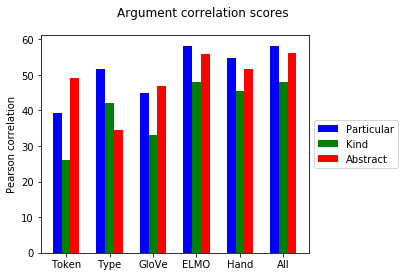

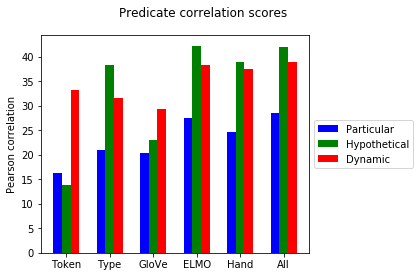

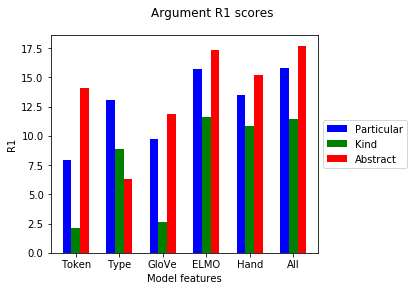

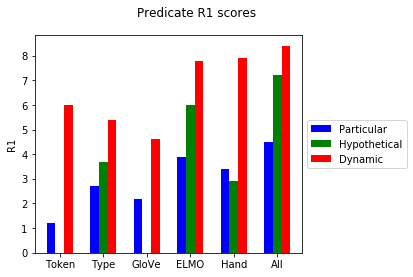

In [32]:
x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [39.2, 51.6, 44.8, 58.2, 54.8, 58.0]
y_kind = [26.0, 42.0, 33.1, 47.9, 45.6, 48.0]
y_abs = [49.2, 34.4, 46.9, 55.8, 51.6, 56.2]

plt.figure()
plt.suptitle('Argument correlation scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('Pearson correlation')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_kind, width=0.2, color='g', align='center', label='Kind')
ax.bar(ind + 0.2, y_abs, width=0.2, color='r', align='center', label='Abstract')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-arg-pear.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [16.3, 20.9, 20.3, 27.5, 24.7, 28.5]
y_hyp = [13.8, 38.3, 22.9, 42.2, 38.8, 42.0]
y_dyn = [33.2, 31.5, 29.4, 38.3, 37.5, 38.8]

plt.figure()
plt.suptitle('Predicate correlation scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('Pearson correlation')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_hyp, width=0.2, color='g', align='center', label='Hypothetical')
ax.bar(ind + 0.2, y_dyn, width=0.2, color='r', align='center', label='Dynamic')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-pred-pear.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [7.9, 13.1, 9.7, 15.7, 13.5, 15.8]
y_kind = [2.1, 8.9, 2.6, 11.6, 10.8, 11.4]
y_abs = [14.1, 6.3, 11.9, 17.3, 15.2, 17.7]

plt.figure()
plt.suptitle('Argument R1 scores')
ax = plt.subplot(111)
ax.set_xlabel('Model features')
ax.set_ylabel('R1')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_kind, width=0.2, color='g', align='center', label='Kind')
ax.bar(ind + 0.2, y_abs, width=0.2, color='r', align='center', label='Abstract')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-arg-r1.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [1.2, 2.7, 2.2, 3.9, 3.4, 4.5]
y_hyp = [0, 3.7, 0, 6.0, 2.9, 7.2]
y_dyn = [6.0, 5.4, 4.6, 7.8, 7.9, 8.4]

plt.figure()
plt.suptitle('Predicate R1 scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('R1')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_hyp, width=0.2, color='g', align='center', label='Hypothetical')
ax.bar(ind + 0.2, y_dyn, width=0.2, color='r', align='center', label='Dynamic')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-pred-r1.png')

# SPR

In [33]:
arg_data_spr = arg_data_unq.copy()
arg_data_spr['Sentence.ID'] = arg_data_spr['Sentence.ID'].str.replace('sent_', '', regex=False)
arg_data_spr['Unique.ID'] = arg_data_spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x['Span']).split(',')[0] + "_" + str(x['Span']).split(',')[-1], axis=1)
arg_data_spr = arg_data_spr.dropna()
arg_data_spr = arg_data_spr.groupby('Unique.ID', as_index=True).mean()

datafile_ = home + "/Research/protocols/data/spr/protoroles_eng_ud1.2_11082016.tsv"
spr = pd.read_csv(datafile_, sep="\t")
# pred_data token is 0 indexed in SPR
spr['Unique.ID'] = spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Arg.Tokens.Begin"]) + "_" + str(x["Arg.Tokens.End"]), axis=1)
spr = spr[~spr['Is.Pilot']]
spr = spr.dropna()

spr = spr[spr['Split'].isin(['train', 'dev'])]

properties = ['awareness', 'volition', 'sentient', 'instigation', 'existed_before', 'existed_during', 'existed_after', 'was_for_benefit', 'change_of_location', 'change_of_state', 'was_used', 'change_of_possession', 'partitive']

print("Arg\n")
for prop in properties:
    prop_df = spr[spr['Property'] == prop]
    prop_df.loc[:, 'Response.ridit'] = prop_df.groupby('Annotator.ID')['Response'].transform(ridit)
    prop_df = prop_df.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)
    prop_df = prop_df.loc[:, ['Unique.ID', 'Response.ridit']].dropna()

    for attr in attributes_arg:
        prop_df.loc[:, attr] = prop_df['Unique.ID'].apply(lambda x: arg_data_spr.loc[x][attr] if x in arg_data_spr.index else None)

    prop_df = prop_df.dropna()
    print(prop.replace('_', ' '), 
          '&', np.round(spearmanr(prop_df[attributes_arg[0]].values, prop_df['Response.ridit'].values)[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_arg[1]].values, prop_df['Response.ridit'].values)[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_arg[2]].values, prop_df['Response.ridit'].values)[0], 2), "\\\\")


pred_data_spr = pred_data_unq.copy()
pred_data_spr['Sentence.ID'] = pred_data['Sentence.ID'].str.replace('sent_', '', regex=False)

lst_col = 'Context.Span'
x = pred_data_spr.assign(**{lst_col: pred_data_spr[lst_col].str.split(';')})
pred_data_spr = pd.DataFrame({col: np.repeat(x[col].values, x[lst_col].str.len()) for col in x.columns.difference([lst_col])}).assign(**{lst_col: np.concatenate(x[lst_col].values)})[x.columns.tolist()]
pred_data_spr['Unique.ID'] = pred_data_spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x['Context.Span']).split(',')[0] + "_" + str(x['Context.Span']).split(',')[-1], axis=1)
pred_data_spr = pred_data_spr.dropna()
pred_data_spr = pred_data_spr.groupby('Unique.ID', as_index=True).mean()

print("\nPred\n")
for prop in properties:
    prop_df = spr[spr['Property'] == prop]
    prop_df.loc[:, 'Response.ridit'] = prop_df.groupby('Annotator.ID')['Response'].transform(ridit)
    prop_df = prop_df.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)
    prop_df = prop_df.loc[:, ['Unique.ID', 'Response.ridit']].dropna()
    for attr in attributes_pred:
        prop_df.loc[:, attr] = prop_df['Unique.ID'].apply(lambda x: pred_data_spr.loc[x][attr] if x in pred_data_spr.index else None)
    prop_df = prop_df.dropna()

    print(prop.replace('_', ' '), 
          '&', np.round(spearmanr(prop_df[attributes_pred[0]].values, prop_df['Response.ridit'])[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_pred[1]].values, prop_df['Response.ridit'])[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_pred[2]].values, prop_df['Response.ridit'])[0], 2), "\\\\")

Arg

awareness & 0.17 & -0.1 & -0.16 \\
volition & 0.16 & -0.1 & -0.15 \\
sentient & 0.17 & -0.08 & -0.15 \\
instigation & 0.09 & -0.08 & -0.08 \\
existed before & 0.17 & -0.03 & -0.18 \\
existed during & 0.11 & -0.03 & -0.08 \\
existed after & 0.16 & -0.06 & -0.14 \\
was for benefit & 0.12 & -0.08 & -0.12 \\
change of location & 0.07 & 0.05 & -0.16 \\
change of state & -0.02 & 0.02 & -0.03 \\
was used & 0.08 & -0.03 & -0.09 \\
change of possession & -0.03 & 0.11 & -0.02 \\
partitive & -0.02 & 0.03 & -0.05 \\

Pred

awareness & -0.06 & 0.09 & -0.06 \\
volition & 0.01 & 0.04 & -0.02 \\
sentient & -0.04 & 0.05 & -0.01 \\
instigation & -0.04 & 0.02 & 0.01 \\
existed before & -0.03 & -0.0 & -0.01 \\
existed during & 0.01 & -0.0 & 0.02 \\
existed after & -0.0 & 0.05 & 0.01 \\
was for benefit & 0.02 & 0.03 & 0.01 \\
change of location & 0.04 & -0.04 & -0.03 \\
change of state & 0.07 & -0.02 & -0.01 \\
was used & -0.03 & -0.02 & 0.09 \\
change of possession & 0.04 & -0.01 & 0.01 \\
partitive 

# Analysis in paper

In [34]:
sigdig = 1
arg_dev = pd.read_csv('dev_preds_arg.tsv', sep='\t')
pred_dev = pd.read_csv('dev_preds_pred.tsv', sep='\t')

attributes_arg_dev = ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']
attributes_pred_dev = ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']

pron_df = arg_dev[arg_dev['Lemma'].isin(['you', 'they'])]
print("Pronomial sentences containing you/they with high Is.Kind values\n")
print(pron_df[pron_df['Is.Kind.Norm'] > 0]['Sentences'].sample(5), "\n")

hyp_df = pred_dev[(pred_dev['Sentences'].str.contains('if'))]
print("Conditional sentences(with if) with low Is.Hypothetical scores\n")
print(pred_dev[(pred_dev['Sentences'].str.contains('if ', regex=False)) & 
               (pred_dev['Is.Hypothetical.Pred'] < -0.3)]['Sentences'].sample(5), "\n")

Pronomial sentences containing you/they with high Is.Kind values

3126    cats react to the treatment they receive , they are not toys .                                                                                                                                       
809     You got ta get an iPhone for 3G ... only way ... actually there is a thing that you pay for monthly that gets wifi from satellite and you can connect to it anywhere but you have to Cary it with you
1467    Called to check if they had a product I 've been using on my dog for years ... the boy who answered the phone could n't possibly have been ruder to me .                                             
698     i am from mexico traveling to san francisco california one week i wan na meet american girls there where i can find them ?                                                                           
2230    Will you be providing an execution version with questions removed / blanks filled in ?                

## Thing words

/Users/venkat/anaconda3/envs/nlp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


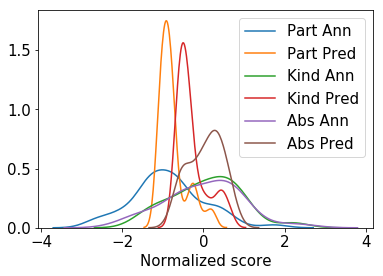

In [35]:
mpl.rcParams.update({'font.size': 15})
thing_words = arg_dev[arg_dev['Lemma'].str.contains('thing')]

plt.figure()
sns.distplot(thing_words['Is.Particular.Norm'], hist=False, label='Part Ann').get_figure()
sns.distplot(thing_words['Is.Particular.Pred'], hist=False, label='Part Pred').get_figure()
sns.distplot(thing_words['Is.Kind.Norm'], hist=False, label='Kind Ann').get_figure()
sns.distplot(thing_words['Is.Kind.Pred'], hist=False, label='Kind Pred').get_figure()
sns.distplot(thing_words['Is.Abstract.Norm'], hist=False, label='Abs Ann').get_figure()
sns.distplot(thing_words['Is.Abstract.Pred'], hist=False, label='Abs Pred').get_figure()
plt.xlabel('Normalized score')
plt.show()
# plt.savefig('things.png', transparent=True)

## POS and DEPREL

In [36]:
print("\nArg POS")
pprint([(a, len(arg_dev[arg_dev['POS'] == a])) for a in list(set(arg_dev['POS'].tolist()))])
for pos in list(set(arg_dev['POS'].tolist())):
    data_new = arg_dev[arg_dev['POS'] == pos]
    print(pos, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig),
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']].values) * 100, sigdig), "\\\\")

print("\nArg DEPREL")
pprint([(a, len(arg_dev[arg_dev['DEPREL'] == a])) for a in list(set(arg_dev['DEPREL'].tolist()))])
for deprel in list(set(arg_dev['DEPREL'].tolist())):
    data_new = arg_dev[arg_dev['DEPREL'] == deprel]
    print(deprel, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']].values) * 100, sigdig), "\\\\")


print("\nPred POS")
pprint([(a, len(pred_dev[pred_dev['POS'] == a])) for a in list(set(pred_dev['POS'].tolist()))])
for pos in list(set(pred_dev['POS'].tolist())):
    data_new = pred_dev[pred_dev['POS'] == pos]
    print(pos, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")

print("\nPred DEPREL")
pprint([(a, len(pred_dev[pred_dev['DEPREL'] == a])) for a in list(set(pred_dev['DEPREL'].tolist()))])
for deprel in list(set(pred_dev['DEPREL'].tolist())):
    data_new = pred_dev[pred_dev['DEPREL'] == deprel]
    print(deprel,
          '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")


# for pos in list(set(arg_dev['POS'].tolist()).intersection(set(pred_dev['POS'].tolist()))):
#     data_new = arg_dev[arg_dev['POS'] == pos]
#     data_new2 = pred_dev[pred_dev['POS'] == pos]
#     print(pos, 
#           '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred']) * 100, sigdig), "\\\\")

# for deprel in list(set(arg_dev['POS'].tolist()).intersection(set(pred_dev['POS'].tolist()))):
#     data_new = arg_dev[arg_dev['DEPREL'] == deprel]
#     data_new2 = pred_dev[pred_dev['DEPREL'] == deprel]
#     print(deprel, 
#           '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred']) * 100, sigdig), "\\\\")




Arg POS
[('PRON', 490), ('NOUN', 2467), ('DET', 49), ('NUM', 40), ('PROPN', 565)]
PRON & 24.5 & 2.4 & 30.1 & 4.3 & 5.3 & -6.5 & 0.1 \\
NOUN & 49.9 & 15.0 & 41.1 & 8.7 & 59.8 & 20.9 & 14.9 \\
DET & 40.1 & -3.7 & 52.3 & 11.8 & 29.6 & 1.7 & 2.7 \\
NUM & 16.4 & -3.0 & 38.4 & 8.5 & -2.5 & -1.9 & 1.0 \\
PROPN & 32.4 & -5.1 & 32.3 & 2.4 & 21.0 & -4.5 & -2.6 \\

Arg DEPREL
[('conj', 38),
 ('parataxis', 16),
 ('acl:relcl', 7),
 ('iobj', 25),
 ('root', 159),
 ('nsubj', 1144),
 ('nmod:tmod', 65),
 ('nsubjpass', 110),
 ('advcl', 19),
 ('nmod:npmod', 24),
 ('nmod', 943),
 ('appos', 4),
 ('xcomp', 27),
 ('nmod:poss', 5),
 ('dobj', 1000),
 ('ccomp', 18),
 ('csubj', 2),
 ('acl', 3),
 ('advmod', 2)]
conj & 43.6 & 3.9 & 41.5 & 16.1 & 78.3 & 30.8 & 17.2 \\
parataxis & 28.3 & -14.7 & 50.8 & 6.7 & 84.3 & 31.2 & 5.9 \\
acl:relcl & 50.1 & 18.1 & 0.6 & -13.3 & 83.3 & 17.2 & 1.8 \\
iobj & 41.9 & 6.7 & 60.7 & 18.2 & -9.7 & -7.6 & 4.8 \\
root & 44.5 & 4.5 & 30.3 & -0.4 & 62.2 & 24.4 & 9.1 \\
nsubj & 55.4 & 19.4

/Users/venkat/anaconda3/envs/nlp/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/venkat/Research/rnn_analysis/svm/factslab/utility/utility.py:566: RuntimeWarning: divide by zero encountered in double_scalars
  r1 = 1 - (model_mae / baseline_mae)
/Users/venkat/Research/rnn_analysis/svm/factslab/utility/utility.py:582: RuntimeWarning: divide by zero encountered in double_scalars
  r1 += factor[ind] * (1 - (model_mae[ind] / baseline_mae[ind]))


xcomp & 22.3 & 0.6 & 39.7 & 7.2 & 32.7 & 6.8 & 5.0 \\
dobj & nan & -inf & nan & -inf & nan & -inf & -inf \\
ccomp & 19.2 & 1.6 & 36.0 & 9.8 & 30.9 & 5.7 & 5.9 \\
csubj & -4.9 & -11.2 & 27.0 & -1.6 & 45.7 & 7.2 & -2.5 \\
acl & 17.1 & 0.7 & 25.5 & 1.6 & 29.0 & 4.0 & 2.0 \\


In [37]:
pred_dev[(pred_dev['Is.Particular.Norm']<-0.2) & (pred_dev['Is.Hypothetical.Norm']<-0.2)][['Unique.ID', 'Sentences']].sample(5)

,Unique.ID,Sentences
2546,en-ud-dev.conllu sent_638_17,"I used to e-mail Vince Kaminski about the advice on his article "" The Challenge of Pricing and Risk Managing Electricity Derivatives "" and he had mailed me the copy ."
1165,en-ud-dev.conllu sent_1651_12,I 'm very happy with the piano lessons Mrs. Lynda Mcmanus taught me .
2783,"en-ud-dev.conllu sent_772_4,5",for Books that Speak for Themselves ....
1864,en-ud-dev.conllu sent_219_30,"There is a classical logical fallacy , post hoc ergo propter hoc &lcrb; Z happens after X , therefore Z is caused by X &rcrb; , and I keep revising this posting this evening because I do n't want to fall into it ."
1270,"en-ud-dev.conllu sent_1729_3,4,5,6,11",My son was able to advance a full two grades within 9 months !


In [ ]:
 
print(np.round(pearsonr(pred_dev['Is.Particular.Norm'], pred_dev['Is.Hypothetical.Norm'])[0] * 100, sigdig))
print(np.round(pearsonr(pred_dev['Is.Particular.Pred'], pred_dev['Is.Hypothetical.Pred'])[0] * 100, sigdig))
print(np.round(pearsonr(pred_dev['Is.Particular.Norm'], pred_dev['Is.Hypothetical.Pred'])[0] * 100, sigdig))
print(np.round(pearsonr(pred_dev['Is.Particular.Pred'], pred_dev['Is.Hypothetical.Norm'])[0] * 100, sigdig))

In [38]:
sigdig=3
def create_corr_df(df, attributes):
    '''
        Creates a dataframe of correlations among attributes in df
    '''
    df_corr = {}
    for attr in attributes:
        df_corr[attr] = {}
        for attr1 in attributes:
            df_corr[attr][attr1] = np.round(pearsonr(df[attr], df[attr1])[0], sigdig)
    return pd.DataFrame(df_corr)

def create_dist(df, attributes):
    '''
        Finds mean, median, variance of each attribute in df
    '''
    df_props = {}
    for attr in attributes:
        df_props[attr] = {}
        df_props[attr]['mean'] = np.round(np.mean(df[attr]), sigdig)
        df_props[attr]['median'] = np.round(np.median(df[attr]), sigdig) 
        df_props[attr]['var'] = np.round(np.var(df[attr]), sigdig)
    return df_props

## Argument annotations

,Is.Particular.Norm,Is.Kind.Norm,Is.Abstract.Norm
Is.Abstract.Norm,-0.275,-0.117,1.000
Is.Kind.Norm,-0.343,1.000,-0.117
Is.Particular.Norm,1.000,-0.343,-0.275


,Is.Particular.Norm,Is.Kind.Norm,Is.Abstract.Norm
mean,0.109,-0.217,-0.719
median,0.287,-0.389,-0.838
var,1.189,1.066,1.097


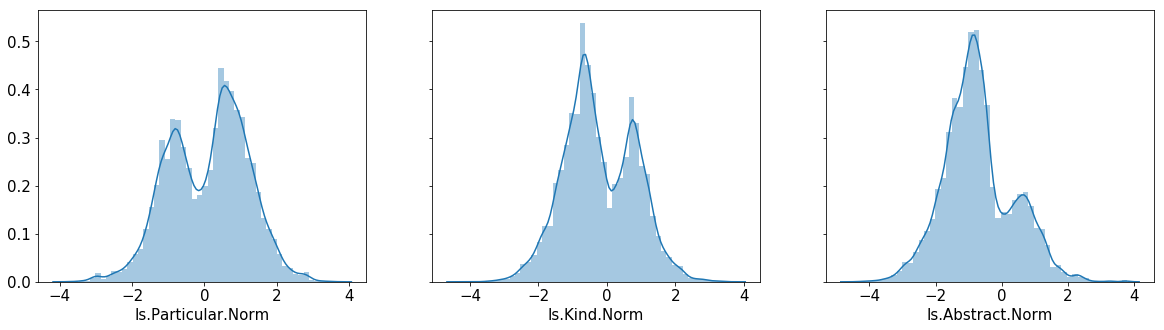

In [39]:
display(pd.DataFrame(create_corr_df(arg_data_unq, attributes_arg)))
display(pd.DataFrame(create_dist(arg_data_unq, attributes_arg)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(arg_data_unq[attributes_arg[i]], ax=ax[0][i]).get_figure()
plt.show()


## Argument predictions

,Is.Particular.Pred,Is.Kind.Pred,Is.Abstract.Pred
Is.Abstract.Pred,-0.675,-0.091,1.000
Is.Kind.Pred,-0.574,1.000,-0.091
Is.Particular.Pred,1.000,-0.574,-0.675


,Is.Particular.Pred,Is.Kind.Pred,Is.Abstract.Pred
mean,0.107,-0.257,-0.776
median,0.262,-0.408,-0.939
var,0.316,0.246,0.250


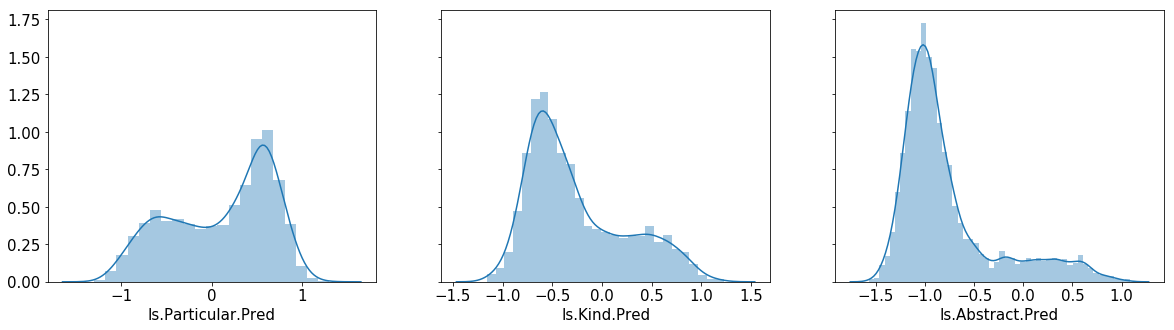

In [40]:
display(pd.DataFrame(create_corr_df(arg_dev, attributes_arg_dev)))
display(pd.DataFrame(create_dist(arg_dev, attributes_arg_dev)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(arg_dev[attributes_arg_dev[i]], ax=ax[0][i]).get_figure()
plt.show()

## Predicate annotations

,Is.Particular.Norm,Is.Hypothetical.Norm,Is.Dynamic.Norm
Is.Dynamic.Norm,-0.007,-0.081,1.000
Is.Hypothetical.Norm,-0.259,1.000,-0.081
Is.Particular.Norm,1.000,-0.259,-0.007


,Is.Particular.Norm,Is.Hypothetical.Norm,Is.Dynamic.Norm
mean,0.394,-0.212,0.097
median,0.527,-0.322,0.218
var,1.085,1.176,1.034


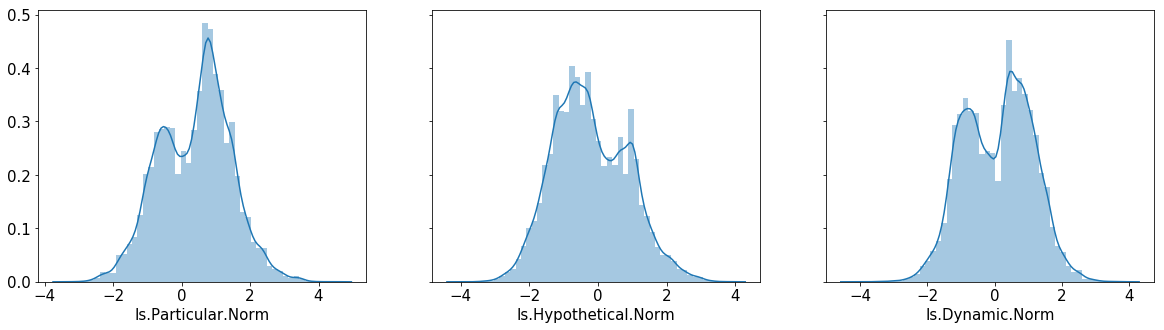

In [41]:
display(pd.DataFrame(create_corr_df(pred_data_unq, attributes_pred)))
display(pd.DataFrame(create_dist(pred_data_unq, attributes_pred)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(pred_data_unq[attributes_pred[i]], ax=ax[0][i]).get_figure()
plt.show()

## Predicate predictions

,Is.Particular.Pred,Is.Hypothetical.Pred,Is.Dynamic.Pred
Is.Dynamic.Pred,0.462,-0.166,1.000
Is.Hypothetical.Pred,-0.899,1.000,-0.166
Is.Particular.Pred,1.000,-0.899,0.462


,Is.Particular.Pred,Is.Hypothetical.Pred,Is.Dynamic.Pred
mean,0.452,-0.243,0.126
median,0.441,-0.306,0.240
var,0.069,0.153,0.147


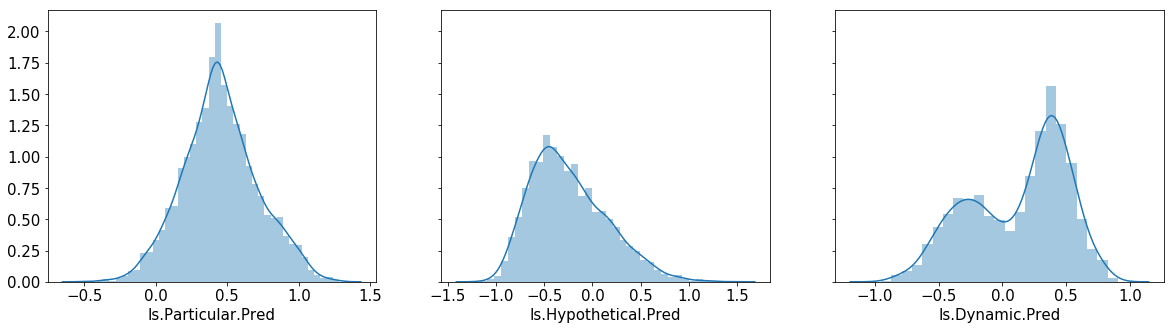

In [42]:
display(pd.DataFrame(create_corr_df(pred_dev, attributes_pred_dev)))
display(pd.DataFrame(create_dist(pred_dev, attributes_pred_dev)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(pred_dev[attributes_pred_dev[i]], ax=ax[0][i]).get_figure()
plt.show()

In [ ]:
display(arg_dev[(arg_dev['Is.Particular.Norm']<-0.2) & (arg_dev['Is.Abstract.Norm']<-0.2)][['Unique.ID', 'Sentences', 'Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Abstract.Norm', 'Is.Abstract.Pred', 'Is.Kind.Norm', 'Is.Kind.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Abstract.Pred'], ascending=False))

## Proper nouns

In [ ]:
upper = arg_dev[(arg_dev['POS']=='PROPN')]

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(upper[attributes_arg[i]], ax=ax[0][i]).get_figure()
plt.show()

display(arg_dev[(arg_dev['POS']=='PROPN')][['Unique.ID', 'Sentences', 'Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Kind.Norm', 'Is.Kind.Pred', 'Is.Abstract.Norm', 'Is.Abstract.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Kind.Pred'], ascending=False))

### Particular and dynamic predicates

In [ ]:
display(pred_dev[(pred_dev['Is.Particular.Pred']>0.1) & (pred_dev['Is.Dynamic.Pred']>0.1)][['Unique.ID', 'Sentences', 'Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Hypothetical.Norm', 'Is.Hypothetical.Pred', 'Is.Dynamic.Norm', 'Is.Dynamic.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Dynamic.Pred'], ascending=False))

### Particular and hypothetical predicates

In [ ]:
display(pred_dev[(pred_dev['Is.Particular.Pred']>0.1) & (pred_dev['Is.Hypothetical.Pred']>0.1)][['Unique.ID', 'Sentences', 'Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Hypothetical.Norm', 'Is.Hypothetical.Pred', 'Is.Dynamic.Norm', 'Is.Dynamic.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Hypothetical.Pred'], ascending=False))

## Clausal versus other DEPREL

In [ ]:
clause_deprel = ['csubj', 'ccomp', 'xcomp', 'advcl', 'acl']
other_deprel = ['root', 'conj', 'parataxis']

pprint([(a, len(pred_dev[pred_dev['DEPREL'].isin(a)])) for a in [clause_deprel, other_deprel]])

for deprel_set in [clause_deprel, other_deprel]:
    data_new = pred_dev[pred_dev['DEPREL'].isin(deprel_set)]
    print('&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")
print(np.round(pearsonr(pred_dev['Is.Particular.Norm'], pred_dev['Is.Particular.Pred'])[0] * 100, sigdig), '&', np.round(r1_score(pred_dev['Is.Particular.Norm'], pred_dev['Is.Particular.Pred']) * 100, sigdig))